
Simulate forcing ACL pathway in the NP11 model.And observe what happens with XPK. 
* You can  make a graph with flux of (phosphoketolase (fructose 6-phosphate)) on y axis and ACL on x axis, if you do forcing simulations in few steps. You will obtain like a linear line. 
* FBA params: I suggest Glc max at 0.05 GR and another round for 0.3 GR. 
* And extract cofactor balances, and compare how it changes when ACL is forced to have a flux. Especially NADH.



In [1]:
import cobra
import pandas as pd 
import os
from os.path import join
from cobra import Model, Reaction, Metabolite
from cobra.sampling import sampling
import numpy as np
os.environ["R_HOME"] = f"{os.environ['CONDA_PREFIX']}\\Lib\\R"
import rpy2.robjects
from plotnine import *
import matplotlib.pyplot as plt

In [2]:
# For getting IDs of all rxns
model1=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\NP11\\rhto.xml")

model1.objective = 'r_1714' # glc ex rxn
solution1 = model1.optimize()
all_fluxes = solution1.fluxes.to_frame(name='Flux')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-21


In [3]:
# Glc max at 0.05 GR and another round for 0.3 GR

ACITL_c_bounds = [0.081856785,0.157705663,0.252251182,0.339119139,0.394261908,0.474691337]
growth_rates = [0.049, 0.100, 0.151, 0.203, 0.25, 0.301]

all_fluxes_glc_max = pd.DataFrame(columns=['Glucose uptake', 'Growth rate', *all_fluxes.index], index=range(len(growth_rates))) #flux_values.index gives the row names column, * extracts the list of strings

for i in range(len(growth_rates)):
    model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\NP11\\rhto.xml")
    model.reactions.r_4041.bounds = growth_rates[i], growth_rates[i]
    # model.reactions.y200003.bounds = ACITL_c_bounds[i], ACITL_c_bounds[i]
    model.reactions.r_1714.bounds = -9999, 9999
    model.objective = 'r_1714'
    solution = model.optimize()
    all_fluxes_glc_max.loc[i] = solution.fluxes[['r_1714', 'r_4041', *all_fluxes.index]].values
    
all_fluxes_glc_max

,Glucose uptake,Growth rate,r_0001,r_0002,r_0003,r_0004,r_0005,r_0006,r_0007,r_0012,...,y300064,y300065,y300066,y300068,y300069,y300070,y300072,y300074,y300075,y300078
0,-0.697522,0.049,0.0,0.0,0.0,0.0,0.052839,0.017649,0.002654,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.314944,0.1,0.0,0.0,0.0,0.0,0.107835,0.036019,0.005417,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.932368,0.151,0.0,0.0,0.0,0.0,0.16283,0.054389,0.008179,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-2.561897,0.203,0.0,0.0,0.0,0.0,0.218904,0.073119,0.010996,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-3.130894,0.25,0.0,0.0,0.0,0.0,0.269586,0.090048,0.013542,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-3.748316,0.301,0.0,0.0,0.0,0.0,0.324582,0.108418,0.016304,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Exchange fluxes
exchange_fluxes_table = all_fluxes_glc_max[['r_4041', 'r_1714', 'r_1992', 'r_1654','r_2060','r_2005', 'r_1672']]

for i in range(len(exchange_fluxes_table.columns)):
    exchange_fluxes_table = exchange_fluxes_table.rename(columns = {exchange_fluxes_table.columns[i]: getattr(model.reactions, exchange_fluxes_table.columns[i]).name})

exchange_fluxes_table

,biomass pseudoreaction,D-glucose exchange,oxygen exchange,ammonium exchange,sulphate exchange,phosphate exchange,carbon dioxide exchange
0,0.049,-0.697522,-2.002213,-0.201366,-0.004165,-0.010765,2.162445
1,0.1,-1.314944,-3.434728,-0.41095,-0.008501,-0.021969,3.761732
2,0.151,-1.932368,-4.867243,-0.620535,-0.012836,-0.033174,5.361022
3,0.203,-2.561897,-6.327847,-0.834229,-0.017257,-0.044598,6.991668
4,0.25,-3.130894,-7.648008,-1.027376,-0.021252,-0.054923,8.465522
5,0.301,-3.748316,-9.080523,-1.236961,-0.025588,-0.066128,10.064809


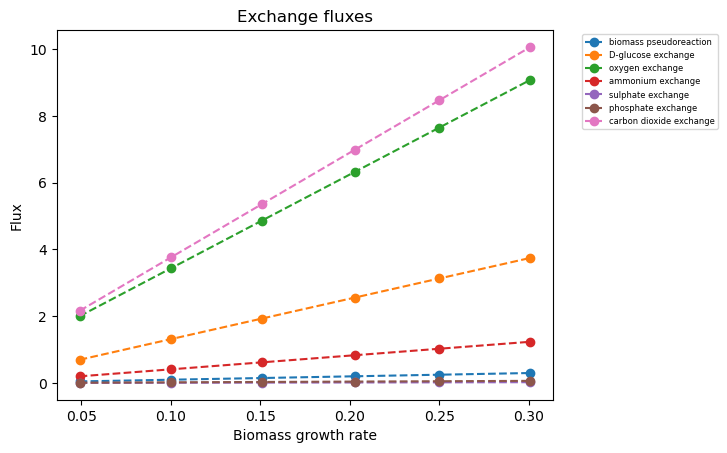

In [5]:
# Exchange fluxes plot

plt.plot(growth_rates, np.abs(exchange_fluxes_table[exchange_fluxes_table.columns]), 'o--', label = exchange_fluxes_table.columns)

plt.xlabel('Biomass growth rate')
plt.ylabel('Flux')
plt.title("Exchange fluxes")
plt.legend(fontsize=6, loc='upper left', bbox_to_anchor=(1.05, 1))
# plt.yticks(range(0, 20, 1))
plt.show()

In [6]:
PPP_fluxes = all_fluxes_glc_max[['r_4041', 'r_1714', 'r_0466', 'r_1049', 'r_1048','r_1050', 't_0081', 'r_0450','r_0959','r_0961']]
# Change G6PDH2rp column name to oxpp 

for i in range(len(PPP_fluxes.columns)):
    PPP_fluxes = PPP_fluxes.rename(columns = {PPP_fluxes.columns[i]: getattr(model.reactions, PPP_fluxes.columns[i]).name})

PPP_fluxes = PPP_fluxes.rename(columns = {'glucose 6-phosphate dehydrogenase': 'oxpp'})
PPP_fluxes

,biomass pseudoreaction,D-glucose exchange,oxpp,transketolase 1,transaldolase,transketolase 2,phosphoketolase,fructose-bisphosphate aldolase,pyruvate decarboxylase,pyruvate dehydrogenase
0,0.049,-0.697522,0.287162,0.066611,0.066611,0.058317,0.081857,0.376398,0.096832,0.614799
1,0.1,-1.314944,0.583708,0.138277,0.0,0.121352,0.157706,0.528324,0.206965,1.03054
2,0.151,-1.932368,0.884929,0.20527,0.0,0.179712,0.252251,0.737512,0.298401,1.460306
3,0.203,-2.561897,1.189673,0.27596,0.27596,0.2416,0.339119,1.231528,0.401162,1.891348
4,0.25,-3.130894,1.459272,0.345695,-1.164343,0.30338,0.394262,0.0,0.517415,2.263415
5,0.301,-3.748316,1.756963,0.416217,0.416217,0.36527,0.474691,1.796806,0.622967,2.682592


In [7]:
# ATPM and ACITL fluxes - didn't find the ID for ATPM
ATPM_ACITL_fluxes = all_fluxes_glc_max[['r_4041', 'r_1714', 'r_4046', 'y200003']] #Didnt find the ID for ATP maintainance rxn, ACS - Acetyl-CoA synthetase
for i in range(len(ATPM_ACITL_fluxes.columns)):
    ATPM_ACITL_fluxes = ATPM_ACITL_fluxes.rename(columns = {ATPM_ACITL_fluxes.columns[i]: getattr(model.reactions, ATPM_ACITL_fluxes.columns[i]).name})

ATPM_ACITL_fluxes

,biomass pseudoreaction,D-glucose exchange,non-growth associated maintenance reaction,ATP-citrate lyase
0,0.049,-0.697522,3.3928,0.0
1,0.1,-1.314944,3.3928,0.0
2,0.151,-1.932368,3.3928,0.0
3,0.203,-2.561897,3.3928,0.0
4,0.25,-3.130894,3.3928,0.0
5,0.301,-3.748316,3.3928,0.0


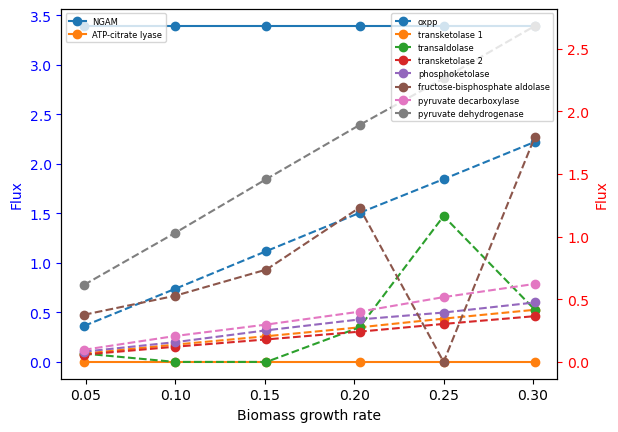

In [8]:
# Plot the PPP enzymes fluxes with ATPM and ACITL on seperate y-axis

# Sample data
x = growth_rates
y1 = np.abs(ATPM_ACITL_fluxes[['non-growth associated maintenance reaction','ATP-citrate lyase']])
y2 = np.abs(PPP_fluxes[['oxpp', 'transketolase 1', 'transaldolase', 'transketolase 2',	'phosphoketolase',	'fructose-bisphosphate aldolase',	'pyruvate decarboxylase',	'pyruvate dehydrogenase']])

fig, ax1 = plt.subplots()

ax1.plot(x, y1, 'o-', label=['NGAM','ATP-citrate lyase'])
ax1.set_xlabel('Biomass growth rate')
ax1.set_ylabel('Flux', color='b')
ax1.tick_params('y', colors='b')
ax1.legend(fontsize=6, loc='upper left')

# Create the second y-axis on the right
ax2 = ax1.twinx()

# Plot the second set of data on the right y-axis 
ax2.plot(x, y2, 'o--', label=['oxpp', 'transketolase 1', 'transaldolase', 'transketolase 2',	'phosphoketolase',	'fructose-bisphosphate aldolase',	'pyruvate decarboxylase',	'pyruvate dehydrogenase'])
ax2.set_ylabel('Flux', color='r')
ax2.tick_params('y', colors='r')
ax2.legend(fontsize=6, loc='upper right')

# Show the plot
plt.show()

Text(0.5, 1.0, 'ATP citrate lyase vs phosphoketolase (fructose 6-phosphate)')

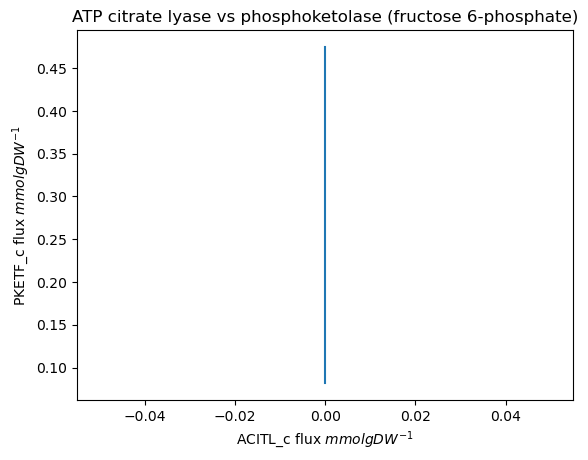

In [9]:
# PKETF_c on y and ACITL on x

plt.plot(ATPM_ACITL_fluxes['ATP-citrate lyase'], PPP_fluxes['phosphoketolase'], '-')
plt.xlabel(r'ACITL_c flux $mmol gDW^{−1}$')
plt.ylabel(r'PKETF_c flux $mmol gDW^{−1}$')
plt.title('ATP citrate lyase vs phosphoketolase (fructose 6-phosphate)')

In [10]:
# Cofactor lists
nadphs = ['s_1212', 's_1213', 's_1214', 's_1215', 's_2799','s_2952']
nadhs = ['s_1203', 's_1204', 's_1205', 's_1206', 's_1206', 's_3753']
atps = ['s_0434', 's_0435', 's_0437', 's_3881', 's_0438', 's_0439', 's_3359', 's_2840', 's_2831', 's_2856', 's_3341'] 

# Make a function for getting cofactor fluxes (all reactions where given metabolite is and their fluxes)

def cofactor_all_rxn_fluxes(cofactor_list, i):
    producing_fluxes = pd.DataFrame() 
    consuming_fluxes = pd.DataFrame()
    
    model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\NP11\\rhto.xml")   
    model.reactions.r_4041.bounds = growth_rates[i], growth_rates[i]
    model.reactions.r_1714.bounds = -9999, 9999
    model.reactions.y200003.bounds = ACITL_c_bounds[i], ACITL_c_bounds[i]
    model.objective = 'r_1714'
    solution = model.optimize()

    for metabolite in cofactor_list:
        producing_fluxes = pd.concat([producing_fluxes, getattr(model.metabolites, metabolite).summary().producing_flux])
        consuming_fluxes = pd.concat([consuming_fluxes, getattr(model.metabolites, metabolite).summary().consuming_flux])
    
    for reaction in producing_fluxes.index:
        if reaction in consuming_fluxes.index and abs(round(producing_fluxes.loc[reaction, 'flux'], 3)) == abs(round(consuming_fluxes.loc[reaction, 'flux'], 3)):
            producing_fluxes = producing_fluxes.drop([reaction])
            consuming_fluxes = consuming_fluxes.drop([reaction])
            
    cofactor_fluxes = pd.concat([producing_fluxes, consuming_fluxes])

    cofactor_fluxes = cofactor_fluxes.sort_values(by='flux', ascending=False).drop(columns = ['percent']) # drop percent column, bc these percents are not for nadph sum (the percent is for specific compartment)
    cofactor_fluxes = cofactor_fluxes[(cofactor_fluxes['flux']) != 0.0] # for getting non-zero fluxes only

    cofactor_sum_producing_flux = sum(cofactor_fluxes[cofactor_fluxes['flux'] > 0]['flux']) # for getting the sum of producing fluxes
    cofactor_sum_consuming_flux = sum(cofactor_fluxes[cofactor_fluxes['flux'] < 0]['flux']) # for getting the sum of consumed fluxes
    print(f'SUM produced: {cofactor_sum_producing_flux}, SUM consumed: {cofactor_sum_consuming_flux}')

    if round(cofactor_sum_producing_flux, 3) == round(abs(cofactor_sum_consuming_flux), 3):
        cofactor_fluxes['percent'] = abs(cofactor_fluxes['flux']/cofactor_sum_producing_flux) # add percent column

    return cofactor_fluxes

# Making a pie chart
def cofactor_fluxes_pie_chart(cofactor_fluxes,  title, threshold): # threshold shows the percent of the flux for including in others sector on pie chart 
    import plotly.graph_objects as go
    # The three lines below are for grouping together reactions with low fluxes in producing
    producing_cofactor_fluxes_draw = cofactor_fluxes[(cofactor_fluxes['flux'] > 0).copy()]    
    producing_cofactor_fluxes_draw.loc[producing_cofactor_fluxes_draw['percent'] < threshold, 'reaction'] = 'Other producing'
    producing_cofactor_fluxes_draw = producing_cofactor_fluxes_draw.groupby('reaction')[['percent', 'flux']].sum()        
    
    # The three lines below are for grouping together reactions with low fluxes in consuming 
    consuming_cofactor_fluxes_draw = cofactor_fluxes[(cofactor_fluxes['flux'] < 0).copy()]
    consuming_cofactor_fluxes_draw.loc[consuming_cofactor_fluxes_draw['percent'] < threshold, 'reaction'] = 'Other consuming'
    consuming_cofactor_fluxes_draw = consuming_cofactor_fluxes_draw.groupby('reaction')[['percent', 'flux']].sum()
    
    # y_producing = producing_cofactor_fluxes_draw['percent']
    # labels_producing = producing_cofactor_fluxes_draw[['reaction', 'flux']] 
    
    # y_consuming = abs(consuming_cofactor_fluxes_draw['percent'])
    # labels_consuming = consuming_cofactor_fluxes_draw[['reaction', 'flux']]
    
    producing_and_consuming_fluxes = pd.concat([producing_cofactor_fluxes_draw, consuming_cofactor_fluxes_draw])
    
    # reaction_IDs = pd.concat([labels_producing, labels_consuming])
    model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\NP11\\rhto.xml")   
    model.objective = 'r_1714'
    solution = model.optimize()
    
    reaction_names_w_flux = []
    for reaction in producing_and_consuming_fluxes.index:
        if reaction != 'Other producing' and reaction != 'Other consuming':
            reaction_names_w_flux += [', '.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'%']), getattr(model.reactions, reaction).name, str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 3))])]
        elif reaction == 'Other producing':
            reaction_names_w_flux += [', '.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'%']), 'Other producing', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 3))])] 
        elif reaction == 'Other consuming':
            reaction_names_w_flux += [', '.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'%']), 'Other consuming', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 3))])] 
            
    pie_chart = plt.pie(producing_and_consuming_fluxes.loc[:, 'percent'], labels = reaction_names_w_flux)  #autopct='%1.1f%%' pd.concat([producing_cofactor_fluxes_draw, consuming_cofactor_fluxes_draw])[['flux', 'percent']]
    # plt.legend(producing_and_consuming_fluxes, reaction_names_w_flux, title = 'Reaction names', loc="center left",  bbox_to_anchor=(1, 0, 0.5, 1))
    plt.title(title)
    plt.show()  
    
    return pie_chart


In [11]:
# Get nadph fluxes at lowest biomass growth rate

nadph_fluxes_lowest_GR = cofactor_all_rxn_fluxes(nadphs, 0)
nadph_fluxes_lowest_GR

# Get nadph fluxes at highest biomass growth rate

nadph_fluxes_highest_GR = cofactor_all_rxn_fluxes(nadphs, 5)
nadph_fluxes_highest_GR

# Get nadh fluxes at lowest biomass growth rate

nadh_fluxes_lowest_GR = cofactor_all_rxn_fluxes(nadhs, 0)
nadh_fluxes_lowest_GR

# Get nadh fluxes at highest biomass growth rate

nadh_fluxes_highest_GR = cofactor_all_rxn_fluxes(nadhs, 5)
nadh_fluxes_highest_GR

# Get atp fluxes at lowest biomass growth rate

atp_fluxes_lowest_GR = cofactor_all_rxn_fluxes(atps, 0)
atp_fluxes_lowest_GR

# Get nadph fluxes at highest biomass growth rate

atp_fluxes_highest_GR = cofactor_all_rxn_fluxes(atps, 5)
atp_fluxes_highest_GR

SUM produced: 0.6277019343128076, SUM consumed: -0.6277019343128079
SUM produced: 3.855886320778608, SUM consumed: -3.8558863207786076
SUM produced: 4.5741588363290715, SUM consumed: -4.5741588363290715
SUM produced: 21.626934746499145, SUM consumed: -21.62693474649915
SUM produced: 12.062770493823196, SUM consumed: -12.062770493823196
SUM produced: 55.53041011472998, SUM consumed: -55.530410114729996


,flux,reaction,percent
r_0226,44.077963,r_0226,0.793763
r_0892,4.726064,r_0892,0.085108
r_0962,4.336291,r_0962,0.078089
r_1022,2.142104,r_1022,0.038575
r_0447,0.244375,r_0447,0.004401
...,...,...,...
r_0886,-1.532857,r_0886,0.027604
r_0148,-1.632950,r_0148,0.029406
r_4046,-3.392800,r_4046,0.061098
r_0534,-3.756424,r_0534,0.067646


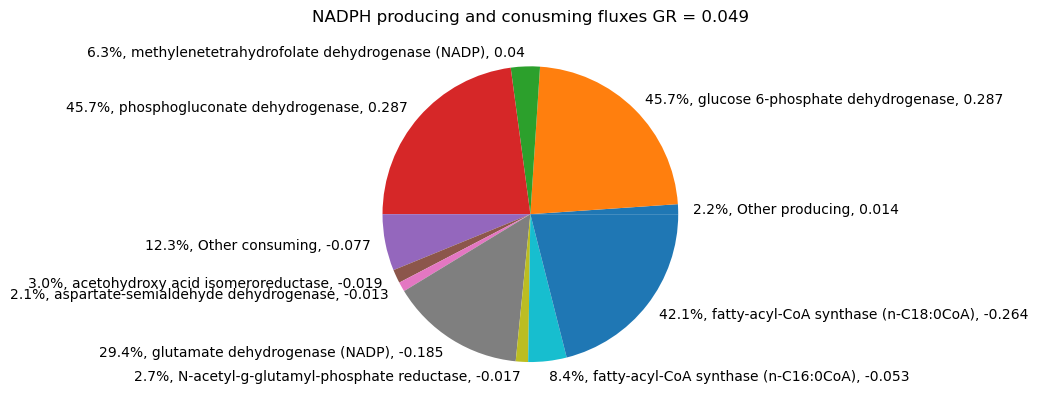

([<matplotlib.patches.Wedge at 0x2713e312d80>,
 [Text(1.0993634361386855, 0.03741704533153962, '2.2%, Other producing, 0.014'),
  Text(0.7768392989073424, 0.7787943911413006, '45.7%, glucose 6-phosphate dehydrogenase, 0.287'),
  Text(-0.037417061414326, 1.0993634355913047, '6.3%, methylenetetrahydrofolate dehydrogenase (NADP), 0.04'),
  Text(-0.827993124270518, 0.7241735884169945, '45.7%, phosphogluconate dehydrogenase, 0.287'),
  Text(-1.0793843182421623, -0.2119657838730168, '12.3%, Other consuming, -0.077'),
  Text(-0.9978234811483556, -0.46297764575514594, '3.0%, acetohydroxy acid isomeroreductase, -0.019'),
  Text(-0.9578903186458917, -0.5407828930767619, '2.1%, aspartate-semialdehyde dehydrogenase, -0.013'),
  Text(-0.5858806374081597, -0.9309908048472921, '29.4%, glutamate dehydrogenase (NADP), -0.185'),
  Text(-0.06287694587171115, -1.0982014795463746, '2.7%, N-acetyl-g-glutamyl-phosphate reductase, -0.017'),
  Text(0.1280758883248231, -1.0925184514825403, '8.4%, fatty-acyl-CoA

In [12]:
# Make a pie plot for napdh
threshold = 0.02 # threshold for including reaction in 'others' in pie chart
title = f'NADPH producing and conusming fluxes GR = {growth_rates[0]}'
producing_nadph_fluxes_lowest_GR_pie_chart = cofactor_fluxes_pie_chart(nadph_fluxes_lowest_GR, title, threshold)
producing_nadph_fluxes_lowest_GR_pie_chart


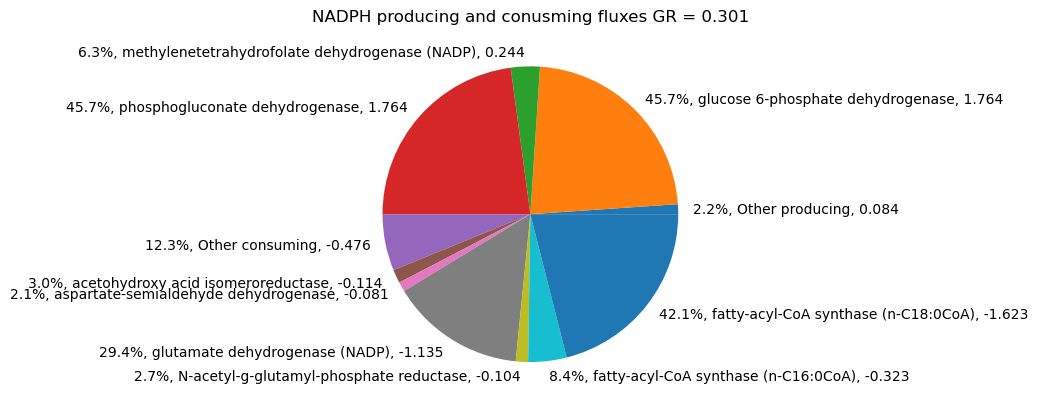

([<matplotlib.patches.Wedge at 0x27140b28560>,
 [Text(1.0993634371239704, 0.03741701638252397, '2.2%, Other producing, 0.084'),
  Text(0.776839303464592, 0.7787943865954915, '45.7%, glucose 6-phosphate dehydrogenase, 1.764'),
  Text(-0.03741701638252386, 1.0993634371239704, '6.3%, methylenetetrahydrofolate dehydrogenase (NADP), 0.244'),
  Text(-0.8279930691813703, 0.7241736514038706, '45.7%, phosphogluconate dehydrogenase, 1.764'),
  Text(-1.0793842004083363, -0.21196638391230072, '12.3%, Other consuming, -0.476'),
  Text(-0.9978229691101791, -0.4629787493137744, '3.0%, acetohydroxy acid isomeroreductase, -0.114'),
  Text(-0.9578897537849241, -0.5407838936154233, '2.1%, aspartate-semialdehyde dehydrogenase, -0.081'),
  Text(-0.5858796023157048, -0.930991456239203, '29.4%, glutamate dehydrogenase (NADP), -1.135'),
  Text(-0.06287566060862913, -1.0982015531326792, '2.7%, N-acetyl-g-glutamyl-phosphate reductase, -0.104'),
  Text(0.1280770262894304, -1.0925183180784004, '8.4%, fatty-acyl-C

In [13]:
# Make a pie plot for napdh
threshold = 0.02 # threshold for including reaction in 'others' in pie chart
title = f'NADPH producing and conusming fluxes GR = {growth_rates[5]}'
producing_nadph_fluxes_highest_GR_pie_chart = cofactor_fluxes_pie_chart(nadph_fluxes_highest_GR, title, threshold)
producing_nadph_fluxes_highest_GR_pie_chart


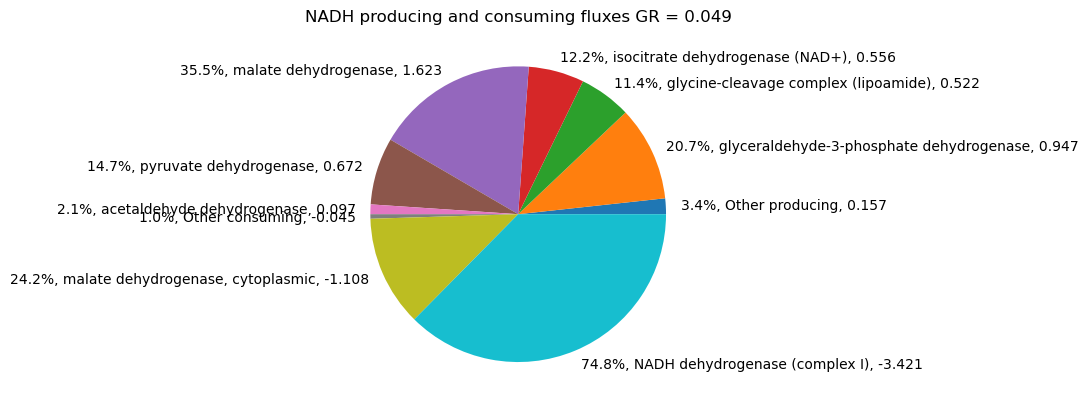

([<matplotlib.patches.Wedge at 0x271417d14f0>,
 [Text(1.0983976579020343, 0.059351369953236796, '3.4%, Other producing, 0.157'),
  Text(0.9983669063373045, 0.46180463437527364, '20.7%, glyceraldehyde-3-phosphate dehydrogenase, 0.947'),
  Text(0.6507230281354889, 0.8868819203559063, '11.4%, glycine-cleavage complex (lipoamide), 0.522'),
  Text(0.2856937324207052, 1.0622518963294567, '12.2%, isocitrate dehydrogenase (NAD+), 0.556'),
  Text(-0.5132716874702644, 0.9729091297965229, '35.5%, malate dehydrogenase, 1.623'),
  Text(-1.0517337152518484, 0.32226726827672714, '14.7%, pyruvate dehydrogenase, 0.672'),
  Text(-1.0993918991378713, 0.036571192351696535, '2.1%, acetaldehyde dehydrogenase, 0.097'),
  Text(-1.0998676062923192, -0.017066007992619325, '1.0%, Other consuming, -0.045'),
  Text(-1.0082234098850917, -0.43986993050182294, '24.2%, malate dehydrogenase, cytoplasmic, -1.108'),
  Text(0.42417488163720635, -1.014926435653374, '74.8%, NADH dehydrogenase (complex I), -3.421')])

In [14]:
# Make a pie plot for nadh 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'NADH producing and consuming fluxes GR = {growth_rates[0]}'
producing_nadh_fluxes_lowest_GR_pie_chart = cofactor_fluxes_pie_chart(nadh_fluxes_lowest_GR, title, threshold)
producing_nadh_fluxes_lowest_GR_pie_chart

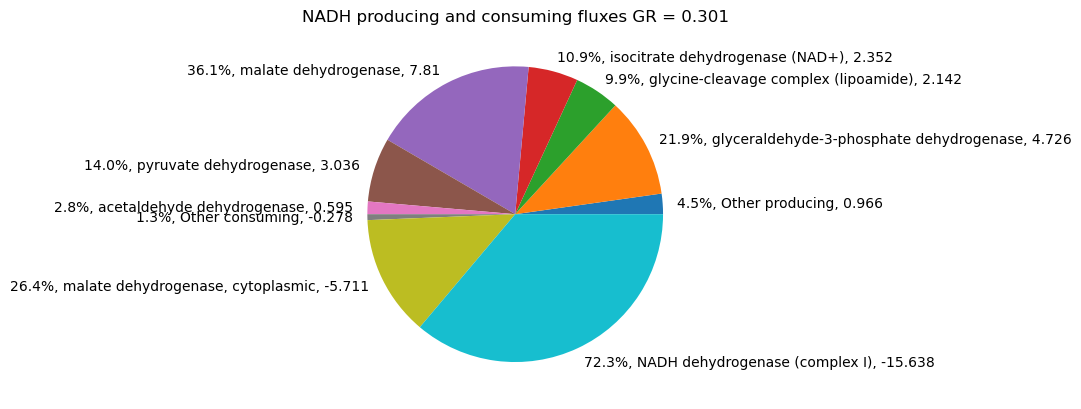

([<matplotlib.patches.Wedge at 0x2714369e570>,
 [Text(1.0972957063154842, 0.07708523141045162, '4.5%, Other producing, 0.966'),
  Text(0.9738947527512952, 0.511399071727251, '21.9%, glyceraldehyde-3-phosphate dehydrogenase, 4.726'),
  Text(0.6105521127799802, 0.9150006106991965, '9.9%, glycine-cleavage complex (lipoamide), 2.142'),
  Text(0.2849056081645589, 1.0624635496977686, '10.9%, isocitrate dehydrogenase (NAD+), 2.352'),
  Text(-0.5041328197594558, 0.9776758665536244, '36.1%, malate dehydrogenase, 7.81'),
  Text(-1.0485879835063217, 0.332360107182174, '14.0%, pyruvate dehydrogenase, 3.036'),
  Text(-1.0989735805548428, 0.04750862282227024, '2.8%, acetaldehyde dehydrogenase, 0.595'),
  Text(-1.0997765209132844, -0.02217214576607812, '1.3%, Other consuming, -0.278'),
  Text(-0.9880251877143869, -0.4835351367190919, '26.4%, malate dehydrogenase, cytoplasmic, -5.711'),
  Text(0.4635218416013909, -0.9975708006745462, '72.3%, NADH dehydrogenase (complex I), -15.638')])

In [15]:
# Make a pie plot for nadh 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'NADH producing and consuming fluxes GR = {growth_rates[5]}'
producing_nadh_fluxes_highest_GR_pie_chart = cofactor_fluxes_pie_chart(nadh_fluxes_highest_GR, title, threshold)
producing_nadh_fluxes_highest_GR_pie_chart


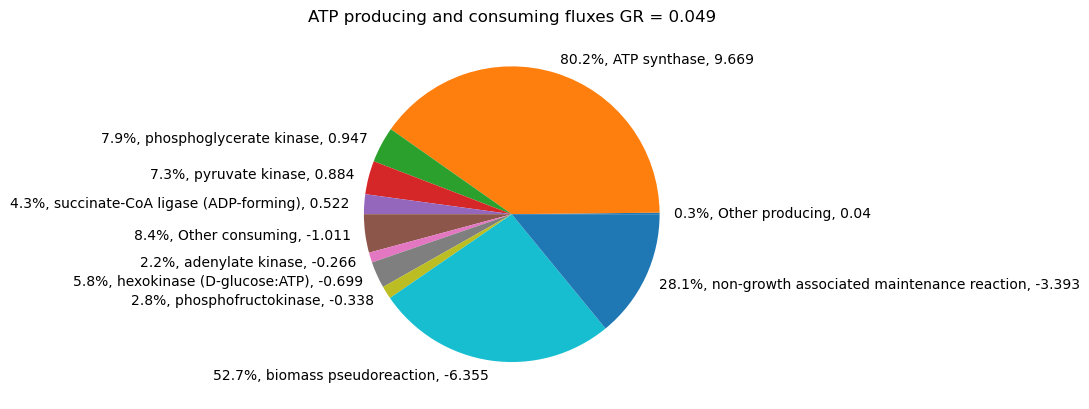

([<matplotlib.patches.Wedge at 0x271442fcda0>,
 [Text(1.0999848006767436, 0.0057825842099149625, '0.3%, Other producing, 0.04'),
  Text(0.32628038791735703, 1.050495648948866, '80.2%, ATP synthase, 9.669'),
  Text(-0.9708422033201265, 0.517170587188137, '7.9%, phosphoglycerate kinase, 0.947'),
  Text(-1.065521490604573, 0.2732470549883555, '7.3%, pyruvate kinase, 0.884'),
  Text(-1.0974596410613364, 0.07471503357104602, '4.3%, succinate-CoA ligase (ADP-forming), 0.522'),
  Text(-1.0904727092430557, -0.14446200329536535, '8.4%, Other consuming, -1.011'),
  Text(-1.0515068815938575, -0.3230066221623969, '2.2%, adenylate kinase, -0.266'),
  Text(-1.002748042301907, -0.4522127415937027, '5.8%, hexokinase (D-glucose:ATP), -0.699'),
  Text(-0.932709842517288, -0.5831400772296277, '2.8%, phosphofructokinase, -0.338'),
  Text(-0.15392493293772727, -1.0891772651961278, '52.7%, biomass pseudoreaction, -6.355'),
  Text(0.994379276887394, -0.47032951608091067, '28.1%, non-growth associated mainten

In [16]:
# Make a pie plot for atp 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'ATP producing and consuming fluxes GR = {growth_rates[0]}'
producing_atp_fluxes_lowest_GR_pie_chart = cofactor_fluxes_pie_chart(atp_fluxes_lowest_GR, title,  threshold)
producing_atp_fluxes_lowest_GR_pie_chart

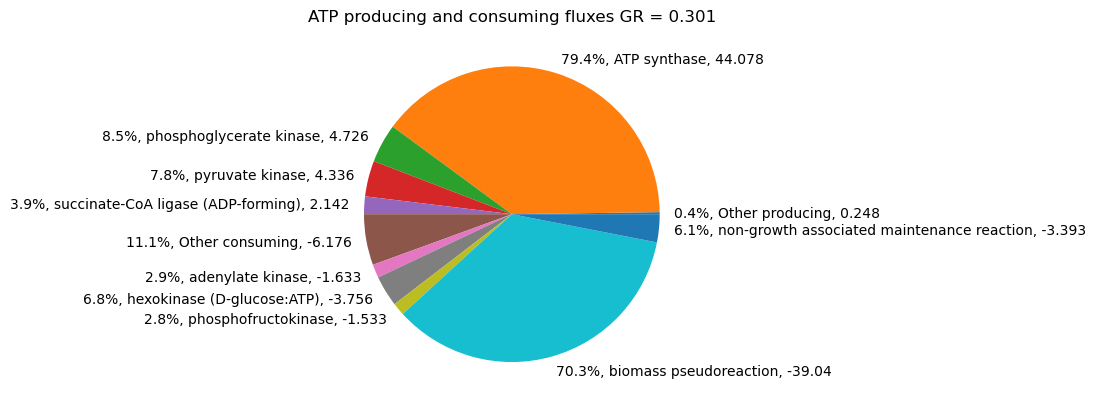

([<matplotlib.patches.Wedge at 0x271451efbf0>,
 [Text(1.0999729357109953, 0.007716262264500931, '0.4%, Other producing, 0.248'),
  Text(0.3354882671662329, 1.0475913433175164, '79.4%, ATP synthase, 44.078'),
  Text(-0.9652367412444087, 0.5275585591684344, '8.5%, phosphoglycerate kinase, 4.726'),
  Text(-1.067457392370949, 0.26558372591823876, '7.8%, pyruvate kinase, 4.336'),
  Text(-1.097981223081903, 0.06661256457732787, '3.9%, succinate-CoA ligase (ADP-forming), 2.142'),
  Text(-1.0832580680352215, -0.19118566378418542, '11.1%, Other consuming, -6.176'),
  Text(-1.0150522115349685, -0.4238738112433577, '2.9%, adenylate kinase, -1.633'),
  Text(-0.9389100924626832, -0.5731036889357071, '6.8%, hexokinase (D-glucose:ATP), -3.756'),
  Text(-0.842993151718315, -0.7066558894936221, '2.8%, phosphofructokinase, -1.533'),
  Text(0.2982038269736145, -1.058808045671306, '70.3%, biomass pseudoreaction, -39.04'),
  Text(1.094937981581289, -0.10540785782233358, '6.1%, non-growth associated mainten

In [17]:
# Make a pie plot for atp 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'ATP producing and consuming fluxes GR = {growth_rates[5]}'
producing_atp_fluxes_highest_GR_pie_chart = cofactor_fluxes_pie_chart(atp_fluxes_highest_GR, title,  threshold)
producing_atp_fluxes_highest_GR_pie_chart

In [18]:
# # Get all fluxes to excel

# with pd.ExcelWriter('C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\NP11\\NP11_fluxes_glc_max_forced_ACITL.xlsx') as excel_writer:
#     all_fluxes_glc_max.to_excel(excel_writer, sheet_name='Glucose max', index=True)

In [19]:
# # Get cofactor data to excel
# with pd.ExcelWriter('C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\NP11\\NP11_cofactor_fluxes_forced_ACITL.xlsx') as excel_writer:
#     nadph_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'NADPH fluxes, GR = {growth_rates[0]}', index=False)
#     nadph_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'NADPH fluxes, GR = {growth_rates[5]}', index=False)
#     nadh_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'NADH fluxes, GR = {growth_rates[0]}', index=False)
#     nadh_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'NADH fluxes, GR = {growth_rates[5]}', index=False)
#     atp_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'ATP fluxes, GR = {growth_rates[0]}', index=False)
#     atp_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'ATP fluxes, GR = {growth_rates[5]}', index=False)